In [2]:
# A set of putative basket and martinotti cells
cells = {
         'Basket':{'segID':[864691135269913253,
                            864691135994717610,
                            864691135644647151,
                            #
                            864691136965924814,
                            864691135875962451,
                            864691135307240262,
                            864691136601891793,
                            864691135341149893,
                            864691135212725632,
                            864691135939796646,
                            864691135269913253,
                            864691135396580129,
                            864691135771743563,
                            864691135446872916,
                            #
                            864691135403927534,
                            864691135815629903,
                            864691135737012612,
                            864691135873741966,
                            864691135644647151,
                            864691135807467037,
                            864691135528023492,
                            864691135212725632,
                            864691137197014081,
                            864691135307240262]},
    
         'Martinotti':{'segID':[864691135654096066,
                                864691136483096108,
                                864691136866902638,
                                864691135390890482,
                                864691136296781083,
                                864691135697569813,
                                864691135575230238,
                                864691136056318680,
                                864691136296781083,
                                #
                                864691136871043694,
                                864691136436386718,
                                864691135394616306,
                                864691135584090435]}
        }

In [3]:
from caveclient import CAVEclient
import nglui
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

In [4]:
def get_synaptic_distances(segID, verbose=True):
    """
    """
    # get soma position
    cell = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':segID})
    # get synapses
    synapses = client.materialize.synapse_query(post_ids=segID)
    distances, exceptions = [], 0
    # loop over synapses 
    for n in range(len(synapses)):
        try:
            distances.append(np.sqrt(\
                                     (synapses.ctr_pt_position[n][0]-cell.pt_position[0][0])**2+\
                                     (synapses.ctr_pt_position[n][1]-cell.pt_position[0][1])**2+\
                                     (synapses.ctr_pt_position[n][2]-cell.pt_position[0][2])**2))
        except BaseException as be:
            # a few synapses do not have the necessary data
            exceptions +=1

    if verbose:
        print('      %i synapses not added (%.2f%%)' % (exceptions,100.*exceptions/len(synapses)))
        
    return distances

In [5]:
for key in ['Basket', 'Martinotti']:
    print(' - %s [...]' % key)
    cells[key]['distances'] = []
    for segID in cells[key]['segID']:
        cells[key]['distances'].append(get_synaptic_distances(segID))

 - Basket [...]
      32 synapses not added (0.22%)
      21 synapses not added (0.36%)
      34 synapses not added (0.35%)
      17 synapses not added (0.23%)
      22 synapses not added (0.26%)
      51 synapses not added (0.39%)
      38 synapses not added (0.29%)
      11 synapses not added (0.14%)
      17 synapses not added (0.24%)
      46 synapses not added (0.39%)
      32 synapses not added (0.22%)
      32 synapses not added (0.34%)
      34 synapses not added (0.28%)
      23 synapses not added (0.28%)
      22 synapses not added (0.24%)
      44 synapses not added (0.34%)
      33 synapses not added (0.24%)
      22 synapses not added (0.31%)
      34 synapses not added (0.35%)
      39 synapses not added (0.46%)
      42 synapses not added (0.37%)
      17 synapses not added (0.24%)
      53 synapses not added (0.60%)
      51 synapses not added (0.39%)
 - Martinotti [...]
      19 synapses not added (0.38%)
      19 synapses not added (0.82%)
      7 synapses not added (

### Plot synaptic count as a function of distance to soma

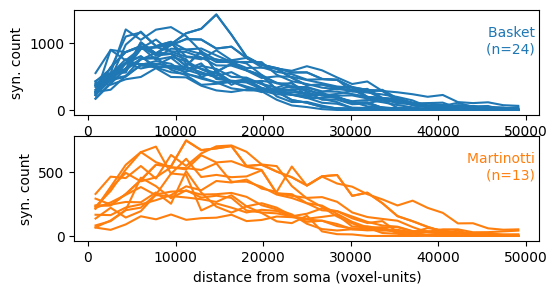

In [6]:
xmax = 100000
xmax = 50000 # zoomed

fig, AX = plt.subplots(2, 1, figsize=(6,3))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    for distances in cells[key]['distances']:
        hist, be = np.histogram(distances, bins=np.linspace(0,xmax,30))
        ax.plot(0.5*(be[1:]+be[:-1]), hist, color=color)
    ax.set_ylabel('syn. count')
    ax.annotate('\n%s \n(n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
_ = plt.xlabel('distance from soma (voxel-units)')

### Plot normalized synaptic count as a function of distance to soma

we normalize either by the sum of synapses (density norm) or by the peak count (max. norm)

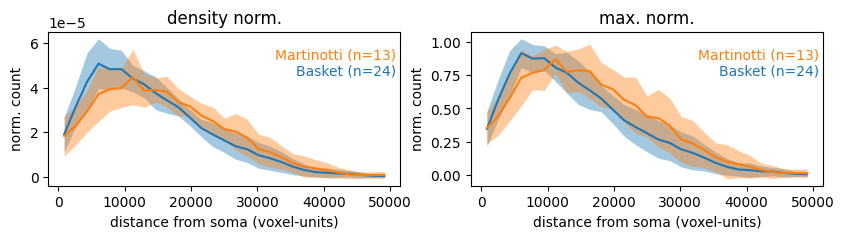

In [7]:
xmax = 100000
xmax = 50000 # zoomed
bins = np.linspace(0,xmax,30)

fig, AX = plt.subplots(1, 2, figsize=(10,2.))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    cells[key]['normD_count'], cells[key]['normM_count'] = [], []
    for distances in cells[key]['distances']:
        # max norm
        hist, be = np.histogram(distances, bins=bins)
        cells[key]['normM_count'].append(hist/hist.max())
        # density norm
        hist, be = np.histogram(distances, bins=bins, density=True)
        cells[key]['normD_count'].append(hist)
        
    mean, sd = np.mean(cells[key]['normD_count'], axis=0), np.std(cells[key]['normD_count'], axis=0)
    AX[0].plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    AX[0].fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
        
    mean, sd = np.mean(cells[key]['normM_count'], axis=0), np.std(cells[key]['normM_count'], axis=0)
    AX[1].plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    AX[1].fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
    for ax in AX:
        ax.annotate('\n'*(2 if key=='Basket' else 1)+'%s (n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
        
_ = AX[0].set_title('density norm.')
_ = AX[1].set_title('max. norm.')
for ax in AX:
    _ = ax.set_xlabel('distance from soma (voxel-units)')
    _ = ax.set_ylabel('norm. count')

In [24]:
def plot_synapses(seg_id, 
                  ax=None, subsampling=10,
                  i=0, j=1, # projection
                  color='k'):
    if ax is None:
        fig, ax = plt.subplots(1)
    
    cell = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':seg_id})
    
    input_df = client.materialize.synapse_query(post_ids=seg_id)
    
    for n in range(len(input_df))[::subsampling]:
        try:
            ax.scatter([1e-3*(input_df.ctr_pt_position[n][i]-cell.pt_position[0][i])],
                       [1e-3*(input_df.ctr_pt_position[n][j]-cell.pt_position[0][j])], s=1, color=color)
        except BaseException as be:
            pass
        
    ax.set_title('cell: "%i" \nhas n=%i synapses' % (seg_id, len(input_df)), fontsize=6)
    ax.axis('equal')


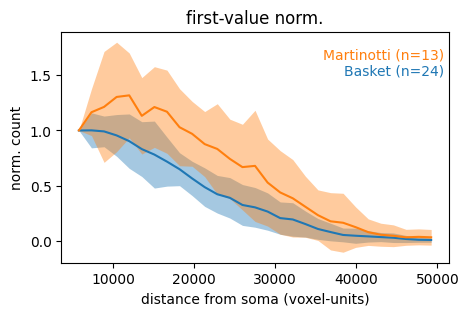

In [31]:
xmax = 100000
xmax = 50000 # zoomed
bins = np.linspace(5000,xmax,30) # starting the count far-enough from the soma

fig, ax = plt.subplots(1, figsize=(5,3.))
for key, color in zip(['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    cells[key]['norm0_count'] = []
    for distances in cells[key]['distances']:
        # norm
        hist, be = np.histogram(distances, bins=bins)
        cells[key]['norm0_count'].append(hist/hist[0])
        
    mean, sd = np.mean(cells[key]['norm0_count'], axis=0), np.std(cells[key]['norm0_count'], axis=0)
    ax.plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    ax.fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
    ax.annotate('\n'*(2 if key=='Basket' else 1)+'%s (n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
        
_ = ax.set_title('first-value norm.')
_ = ax.set_xlabel('distance from soma (voxel-units)')
_ = ax.set_ylabel('norm. count')

## Visualizing synapses

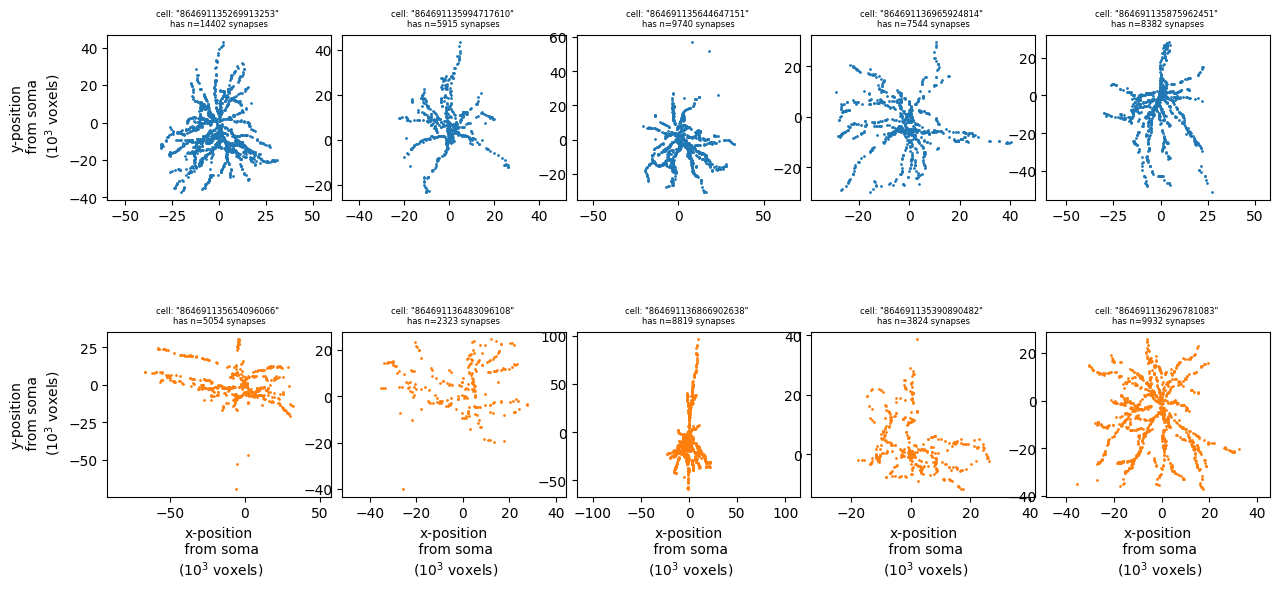

In [32]:
Nplot = 5
fig, AX = plt.subplots(2, Nplot, figsize=(3*Nplot,6))
fig.subplots_adjust(wspace=0.05, hspace=0.8)
for i in range(Nplot):
    plot_synapses(cells['Basket']['segID'][i], ax=AX[0][i], color=plt.cm.tab10(0))
    plot_synapses(cells['Martinotti']['segID'][i], ax=AX[1][i], color=plt.cm.tab10(1))
for ax in [AX[0][0], AX[1][0]]:
    ax.set_ylabel('y-position\n from soma\n (10$^3$ voxels)')
for ax in AX[1]:
    ax.set_xlabel('x-position\n from soma\n (10$^3$ voxels)')